<a href="https://colab.research.google.com/github/muratko357/Netherlands-Crime-Analysis/blob/main/NL_Crime_rates_by_municipality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violent and Sexual Crime Rates by Municipality: The Netherlands, 2018

In [ ]:
# Libararies
import pandas as pd
import geopandas as gpd
import cbsodata
#conda install -c conda-forge descartes
import descartes
import matplotlib.pyplot as plt
%matplotlib inline

## Access Data
Examine the metadata for properties of the data in order to locate geographic information and other variables.

In [ ]:
# View the metadata for the properties of the dataset
metadata = pd.DataFrame(cbsodata.get_meta('84468NED', 'DataProperties'))
print(metadata)

In [ ]:
# View raw data to choose variables
raw_data = cbsodata.get_data('84468NED')
print(raw_data[0])

In [ ]:
# Download the Total Violent and Sexual Crime rates and delete spaces from regional identifiers
data = pd.DataFrame(cbsodata.get_data('84468NED', select = ['WijkenEnBuurten', 'Gemeentenaam_1', 'Codering_3', 'GeweldsEnSeksueleMisdrijven_30']))
data['Codering_3'] = data['Codering_3'].str.strip()

# data = cbsodata.get_data('84468NED', dir="data")     # to save in the directory

In [ ]:
# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)
print(municipal_boundaries.head(2))

### Merge data and remove white space from string data

In [ ]:
# Link data from Statistics Netherlands to geodata
municipal_boundaries = pd.merge(municipal_boundaries, data,
                               left_on = "statcode", 
                               right_on = "Codering_3")

# Get rid of white space from the names of the municipalities
data['Gemeentenaam_1'] = data['Gemeentenaam_1'].str.strip()

## Analysis

Perform data visualization for Total Violent and Sexual Crime rate per 1000 inhabitants in each municipality, according to police records.  

In [ ]:
# The municipalities with the highes crime rates of violent and sexual crime
crimebym = data.groupby('Gemeentenaam_1')['GeweldsEnSeksueleMisdrijven_30'].sum().sort_values(ascending=False)
print("Number of Municipality: ", len(crimebym))
print('Crime Rate by Municipilaty :' + '\n', crimebym.head())

Number of Municipality:  380
Crime Rate by Municipilaty :
 Gemeentenaam_1
Amsterdam         8427.0
's-Gravenhage     2583.0
Haarlemmermeer    2320.0
Tilburg           2280.0
Arnhem            1831.0
Name: GeweldsEnSeksueleMisdrijven_30, dtype: float64


Among 380 municipality recordings, the ones with the highest rates for Violent & Sexual Crime per 1000 inhabitants are identified in the following order: Amsterdam (8427), 's-Gravenhage (2583), Haarlemmermeer (2320), Tilburg (2280), and Arnhem (1831). 

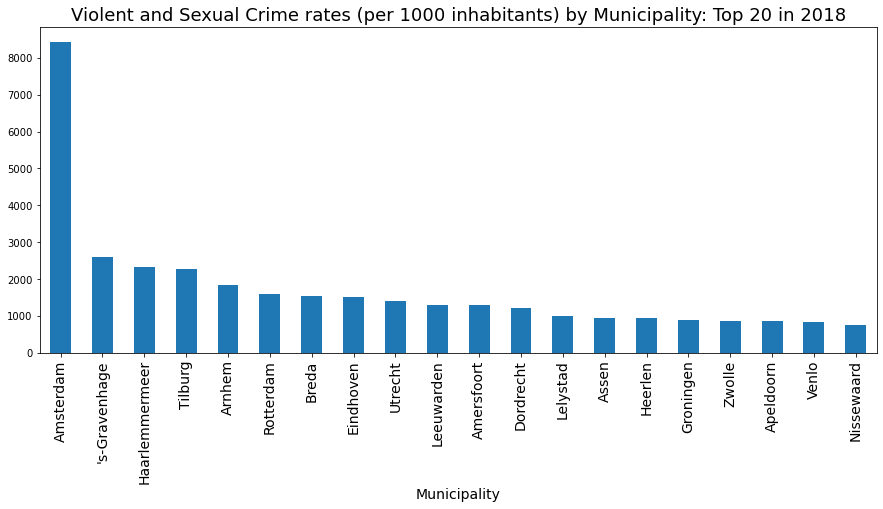

In [ ]:
# Plot the top 20 municipalities with the highest rates
plt.figure(figsize=(15,6))
mun_sort = data.groupby('Gemeentenaam_1')['GeweldsEnSeksueleMisdrijven_30'].sum().sort_values(ascending=False)
mun_sort = mun_sort.head(20)
mun_sort.plot(kind= 'bar')
plt.title('Violent and Sexual Crime rates (per 1000 inhabitants) by Municipality: Top 20 in 2018', fontweight = 30, fontsize = 18)
plt.xlabel('Municipality', fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()


### Mapping

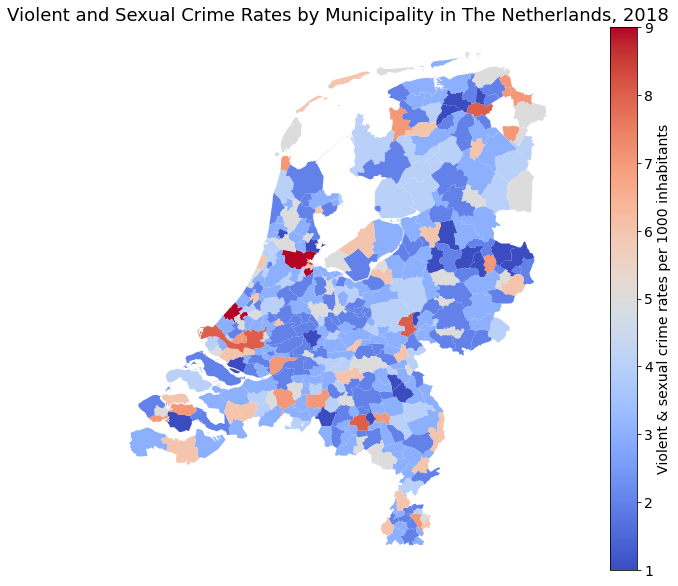

In [ ]:
# Create a thematic map
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1, 1, figsize=[15,10])
mb = municipal_boundaries.plot(column='GeweldsEnSeksueleMisdrijven_30', ax=ax, cmap = 'coolwarm', legend=True,
                               legend_kwds={'label': "Violent & sexual crime rates per 1000 inhabitants", 
                                            'orientation': "vertical"})
mb.axis('off')
ax.set_title('Violent and Sexual Crime Rates by Municipality in The Netherlands, 2018', fontsize=18)
fig.savefig('NL_crime_rates.png', dpi=300)

plt.show()